# Проект e-commerce: вариант 1
Продакт-менеджер Василий попросил проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

3. По каждому товару определить, в какой день недели товар чаще всего покупается.

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

5. Напиши функцию на python, позволяющую строить когортный анализ. В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц. Описание подхода можно найти тут.

6. Построй RFM-кластеры для пользователей. Выведи для каждого кластера средние значения метрик R, F, M (и опиши подробно, как были построены метрики R, F, M). Описание подхода можно найти тут.

In [1]:
import pandas  as pd
import seaborn as sns
import numpy   as np
import datetime
import calendar
from calendar import monthrange
import matplotlib.pyplot as plt
from datetime import datetime, date
from datetime import date,timedelta

## Импорт, описание и предобработка данных

In [2]:
customers = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/FUi5uSd6BfG_ig')
orders    = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/t9Li4JOfgxuUrg')
items     = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw')

#### Таблица с уникальными идентификаторами пользователей customers

In [3]:
customers.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


- customer_id — позаказный идентификатор пользователя (аналог номера паспорта)
- customer_unique_id —  уникальный идентификатор пользователя
- customer_zip_code_prefix —  почтовый индекс пользователя
- customer_city —  город доставки пользователя
- customer_state —  штат доставки пользователя

In [4]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [5]:
customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

In [6]:
#распределение пользователей по штатам
customers.groupby('customer_state').agg({'customer_city' : 'count'})\
         .rename(columns={'customer_city' : 'state'})\
         .describe()

,state
count,27.000000
mean,3683.000000
std,8270.437664
min,46.000000
25%,381.500000
50%,907.000000
75%,2760.000000
max,41746.000000


In [7]:
#распределение пользователей по городам customer_city        
customers.groupby('customer_city').agg({'customer_state' : 'count'})\
         .rename(columns={'customer_state' : 'city'})\
         .describe()

,city
count,4119.000000
mean,24.142025
std,279.272382
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,15540.000000


#### Таблица заказов orders

In [8]:
orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


- order_id —  уникальный идентификатор заказа (номер чека)
- customer_id —  позаказный идентификатор пользователя (аналог номера паспорта)
- order_status —  статус заказа
    - created —  создан
    - approved —  подтверждён
    - invoiced —  выставлен счёт
    - processing —  в процессе сборки заказа
    - shipped —  отгружен со склада
    - delivered —  доставлен пользователю
    - unavailable —  недоступен
    - canceled —  отменён
- order_purchase_timestamp —  время создания заказа
- order_approved_at —  время подтверждения оплаты заказа
- order_delivered_carrier_date —  время передачи заказа в логистическую службу
- order_delivered_customer_date —  время доставки заказа
- order_estimated_delivery_date —  обещанная дата доставки

In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [10]:
#конвертируем формат в datetime
orders.order_purchase_timestamp = pd.to_datetime(orders.order_purchase_timestamp)
orders.order_approved_at = pd.to_datetime(orders.order_approved_at)
orders.order_delivered_carrier_date = pd.to_datetime(orders.order_delivered_carrier_date)
orders.order_delivered_customer_date = pd.to_datetime(orders.order_delivered_customer_date)
orders.order_estimated_delivery_date = pd.to_datetime(orders.order_estimated_delivery_date)

In [11]:
orders.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

In [12]:
#количество заказов по статусам
orders.groupby('order_status', as_index=False)\
      .agg({'order_id' : 'count'})\
      .rename(columns={'order_id' : 'orders'})

,order_status,orders
0,approved,2
1,canceled,625
2,created,5
3,delivered,96478
4,invoiced,314
5,processing,301
6,shipped,1107
7,unavailable,609


#### Товарные позиции, входящие в заказы items

In [13]:
items.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


- order_id —  уникальный идентификатор заказа (номер чека)
- order_item_id —  идентификатор товара внутри одного заказа
- product_id —  ид товара (аналог штрихкода)
- seller_id — ид производителя товара
- shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
- price —  цена за единицу товара
- freight_value —  вес товара

In [14]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [15]:
#конвертируем формат в datetime
items.shipping_limit_date = pd.to_datetime(items.shipping_limit_date)

In [16]:
items.nunique()

order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64

## 1. Сколько у нас пользователей, которые совершили покупку только один раз?

В качестве покупки будем считать именно заказ (order_id), а не товары (product_id), которые входят в этот заказ. Совершенными покупками будем считать только доставленные (присутствует информация в order_delivered_customer_date).

In [17]:
#исключим недосталвенные заказы и посмотрим какие статусы остались
orders.merge(customers, on='customer_id')\
      .fillna(0)\
      .query('order_delivered_customer_date != 0')\
      .order_status.unique()

array(['delivered', 'canceled'], dtype=object)

Так же не будем учитывать отмененные заказы, статус = canceled

In [18]:
#посчитаем пользователей, которые совершили покупку (заказ, order) только один раз
#в расчет не идут не доставленные и отмененные заказы
orders.merge(customers, on='customer_id')\
      .fillna(0)\
      .query('order_delivered_customer_date != 0 & order_status != "canceled"')\
      .groupby('customer_unique_id')\
      .agg({'order_id' : 'count'})\
      .query('order_id == 1')\
      .shape[0]

90549

#### 90549 пользователей совершили покупку (заказ, order) только один раз. Исключены данные по недоставленным и отмененным заказам.

## 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Не доставленными заказами будем считать заказы, для которых отсутствует информация о времени доставки (order_delivered_customer_date) и для которых есть информация об оплате (order_approved_at). В качестве месяца будем брать месяц обещанной доставки (order_estimated_delivery_date). В качестве причины будет выступать order_status, как информация о том, на каком этапе заказ прервался.

In [19]:
#формируем датасет исходя из уловий выше и откинем все ненужные колонки

not_delivered = orders.fillna(0)\
                      .query('order_delivered_customer_date == 0 & order_approved_at != 0')\
                      .drop(columns={'order_id', 
                                     'customer_id', 
                                     'order_purchase_timestamp', 
                                     'order_approved_at', 
                                     'order_delivered_carrier_date', 
                                     'order_delivered_customer_date'})
not_delivered.head(3)

,order_status,order_estimated_delivery_date
6,invoiced,2017-05-09
44,shipped,2018-06-28
103,invoiced,2018-08-21


In [20]:
#формат времени конверттируем в год-месяц и переименуем колонку

not_delivered = not_delivered.rename(columns={'order_estimated_delivery_date': 'month'})
not_delivered.month = not_delivered.month.dt.strftime('%Y-%m')
not_delivered.head(3)

,order_status,month
6,invoiced,2017-05
44,shipped,2018-06
103,invoiced,2018-08


In [21]:
#подсчёт отмененных заказов в каждом месяце с групировкой по причинам

mean_reason = not_delivered.groupby(['month', 'order_status'])\
                           .agg({'month':'count'})\
                           .rename(columns={'month': 'total'})\
                           .reset_index()
mean_reason.head(3)

,month,order_status,total
0,2016-09,canceled,1
1,2016-10,canceled,2
2,2016-10,shipped,1


In [22]:
#развернем таблицу так, чтобы колонками был статус заказа, а строками месяц:

mean_reason = mean_reason.pivot(index='month', columns='order_status', values='total')\
                         .fillna(0)\
                         .reset_index()
mean_reason.head(3)

order_status,month,approved,canceled,delivered,invoiced,processing,shipped,unavailable
0,2016-09,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2016-10,0.0,2.0,0.0,0.0,0.0,1.0,0.0
2,2016-11,0.0,5.0,0.0,9.0,0.0,1.0,5.0


In [23]:
#среднее значение для каждого статуса

monthly_mean_by_reason = mean_reason.mean().reset_index()\
                                           .rename(columns={0:'monthly_mean'})
monthly_mean_by_reason

C:\Users\pletn\AppData\Local\Temp\ipykernel_20132\392228155.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  monthly_mean_by_reason = mean_reason.mean().reset_index()\


,order_status,monthly_mean
0,approved,0.083333
1,canceled,19.916667
2,delivered,0.333333
3,invoiced,13.083333
4,processing,12.541667
5,shipped,46.125000
6,unavailable,25.375000


In [24]:
#отсортируем строки в логической последовательности статусов

not_delivered_by_reason = monthly_mean_by_reason.reindex([0, 3, 4, 5, 2, 6, 1])
not_delivered_by_reason

,order_status,monthly_mean
0,approved,0.083333
3,invoiced,13.083333
4,processing,12.541667
5,shipped,46.125000
2,delivered,0.333333
6,unavailable,25.375000
1,canceled,19.916667


#### Среднее количество не доставленных заказов в месяц с групировкой по этапам содержатся в not_delivered_by_reason
Возможные причины для каждого статуса, из-за чего заказ не был доставлен клиенту:
- approved —  подтверждён. Внутреняя ошибка сервиса. 
- invoiced —  выставлен счёт. Клиент не оплатил заказ. 
- processing —  в процессе сборки заказа. Заказ отсутствует на складе. 
- shipped —  отгружен со склада. Был утерян курьерской службой.
- delivered —  доставлен пользователю. Доставлен неверный заказ. 
- unavailable —  недоступен
- canceled —  отменён

## 3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

Решим эту задачу для двух вариантов:
- Вариант 1: В какие то несколько дней недели количество покупок товара равны и в эти дни покупок больше, чем в другие дни (несколько max).
- Вариант 2: В какой то один единственный день покупок товара будет больше, чем в другие дни (один max).

In [25]:
#возьмем данные item (для каждого заказа детализация по продуктам) и оставим только нужную информацию
prod_weekday = items.drop(columns={'order_id',
                                   'order_item_id',
                                   'seller_id',
                                   'price',
                                   'freight_value'})

#вместо даты перезапишем день недели и переименуем колонку
prod_weekday.shipping_limit_date = prod_weekday.shipping_limit_date.dt.day_name()
prod_weekday = prod_weekday.rename(columns={'shipping_limit_date':'week_day'})
prod_weekday['counter'] = 1 #счётчик для аггрегации
prod_weekday.head()

,product_id,week_day,counter
0,4244733e06e7ecb4970a6e2683c13e61,Tuesday,1
1,e5f2d52b802189ee658865ca93d83a8f,Wednesday,1
2,c777355d18b72b67abbeef9df44fd0fd,Thursday,1
3,7634da152a4610f1595efa32f14722fc,Wednesday,1
4,ac6c3623068f30de03045865e4e10089,Monday,1


In [26]:
#посчитаем для каждого товара общее количество покупок в каждый день недели
prod_weekday = prod_weekday.groupby(['product_id', 'week_day'], as_index=False)\
                           .agg({'counter': 'sum'})\
                           .sort_values(['product_id', 'counter'], ascending=False)
prod_weekday.head()

,product_id,week_day,counter
57079,fffe9eeff12fcbd74a2f2b007dde0c58,Friday,1
57075,fffdb2d0ec8d6a61f0a0a0db3f25b441,Monday,2
57076,fffdb2d0ec8d6a61f0a0a0db3f25b441,Thursday,1
57077,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,1
57078,fffdb2d0ec8d6a61f0a0a0db3f25b441,Wednesday,1


### Вариант 1: Для каждого товара определим все дни недели с максимальным количеством покупок

In [27]:
#создадим датасет в который для каждого продукта запишем максимальное значение покупок в день недели
weekday_max = prod_weekday.groupby(['product_id']).agg({'counter':'max'})\
                          .reset_index()\
                          .rename(columns={'counter':'day_max'})
weekday_max.sort_values('day_max', ascending=False).head()

,product_id,day_max
8613,422879e10f46682990de24d770e7f83d,159
22112,aca2eb7d00ea1a7b8ebd4e68314663af,149
7364,389d119b48cf3043d311335e499d9c6b,145
19742,99a4788cb24856965c36a24e339b6058,141
7079,368c6c730842d78016ad823897a372db,131


In [28]:
#присоеденим максимальные значения к prod_weekday
prod_best_weekday_1 = pd.merge(prod_weekday, weekday_max, how='left', on='product_id')

#оставим только те сторки, для которых значения для каждого дня равны максимальному
prod_best_weekday_1 = prod_best_weekday_1[prod_best_weekday_1['counter'] == prod_best_weekday_1['day_max']]
prod_best_weekday_1 = prod_best_weekday_1.drop(columns='counter')
prod_best_weekday_1.head()

,product_id,week_day,day_max
0,fffe9eeff12fcbd74a2f2b007dde0c58,Friday,1
1,fffdb2d0ec8d6a61f0a0a0db3f25b441,Monday,2
5,fff9553ac224cec9d15d49f5a263411f,Friday,1
6,fff81cc3158d2725c0655ab9ba0f712c,Friday,1
7,fff6177642830a9a94a0f2cba5e476d1,Monday,1


### Вариант 2: Для каждого товара определим единственный день недели с максимальным количеством покупок

In [29]:
#для продуктов имеющих несколько дней с максимальными значениями посчитаем сумму
filter_1 = prod_best_weekday_1.groupby(['product_id']).agg({'day_max':'sum'})
filter_1 = filter_1.reset_index()
filter_1 = filter_1.rename(columns={'day_max':'sum_values'})
#присоеденим колонку с суммой к первому варианту (prod_best_weekday_1)
prod_best_weekday_2 = pd.merge(prod_best_weekday_1, filter_1, how='left', on=['product_id'])
#если для одного товара имеется только одно максимальное значение, то колонка week_day_max будет равна sum_values
prod_best_weekday_2 = prod_best_weekday_2[prod_best_weekday_2['day_max'] == prod_best_weekday_2['sum_values']]
prod_best_weekday_2 = prod_best_weekday_2.drop(columns='sum_values')
prod_best_weekday_2.head()

,product_id,week_day,day_max
0,fffe9eeff12fcbd74a2f2b007dde0c58,Friday,1
1,fffdb2d0ec8d6a61f0a0a0db3f25b441,Monday,2
2,fff9553ac224cec9d15d49f5a263411f,Friday,1
3,fff81cc3158d2725c0655ab9ba0f712c,Friday,1
6,fff515ea94dbf35d54d256b3e39f0fea,Tuesday,1


#### Теперь менеджеру Василию можно отдать два датасета:
1. prod_best_weekday_1 - для каждого товара определены все дни недели, в которые он был куплен максимальное количество раз.
2. prod_best_weekday_2 - для каждого товара определен только один единственный день недели, в который покупок было больше, чем в другие дни.

Однако, стоит обратить внимание менеджера Василия, что для некоторых товаров максимальное число покупок в день достаточно низкое, например 1, 2 и т.д. В таких случаях можно говорить, что на самом деле товар не имеет недельной сезонности, а результаты получены случайно. 

Менеджеру Василию следует задать вопрос - для чего он хочет использовать эту информацию и насколько важное бизнес решение собирается принять? Если он собирается принять хоть сколько-нибудь важное решение, то действуем следующим образом:
Наши данные это только выборка, т.к. магазин работал и будет работать за пределеами наших данных, а товары продаются и в других магазинах, поэтому:
1. Объявим нулевую гипотезу Н0: товар в каждый день недели покупается одинаковое количество раз.
    - наблюдаемые частоты - количество покупок товара в каждый день
    - ожидаемые частоты - общее количество покупок товара разделить на 7 дней
    - уровень значимости примем 0.05
2. Для проверки Н0 будем использовать критерий Хи-квадрат Пирсона. Данный критерий рекомендуется использовать в случае когда для каждой теоретической частоты число вхождений не меньше 5. В связи с этим, удалим все товары, для которых общее число покупок менее 35 (7 дней недели х 5).
3. Если для товара p-value больше 0.05, нулевую гипотезу не отклоняем и различия количества покупок по дням недели не считаем статистически значимым, а значит данный товар убираем из нашего финального отчета. Если p-value меньше 0.05 отклоняем нулевую гипотезу и различия считаем статистически значимыми. А если справедливо утверждение, что различия статистически значимы, значит и справедливо то, что в какой то один или несколько дней недели товар покупается чаще, чем в остальные. Иными словами, что присутствует недельная сезонность. 

## 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 
#### Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

Результирующий датафрейм будет выглядеть следующим образом: строки это уникальные номера пользоваталей (customer_unique_id), столбцы это временные промежутки в формате год_месяц (будет использоваться информация времени оплаты заказа order_approved_at),  значения это среднее количество заказов для пользователя в этот месяц. При этом в расчет среднего значения не должны попасть отмененные заказы (order_status = canceled в данных по заказам orders).

In [30]:
#для начала присоеденим к датафрейму с заказами (orders) данные по уникальным пользователям (customers)
orders_customers = orders.merge(customers, how='outer', on='customer_id')
#получившейся датафрейм объеденим с данными по входящими продуктами в каждый заказ (items)
#т.к. для одной строки order_id будет соответствовать несколько товаров, способ объединения будет outer
orders_customers_items = orders_customers.merge(items, how='outer', on='order_id')
orders_customers_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113425 entries, 0 to 113424
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       113425 non-null  object        
 1   customer_id                    113425 non-null  object        
 2   order_status                   113425 non-null  object        
 3   order_purchase_timestamp       113425 non-null  datetime64[ns]
 4   order_approved_at              113264 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111457 non-null  datetime64[ns]
 6   order_delivered_customer_date  110196 non-null  datetime64[ns]
 7   order_estimated_delivery_date  113425 non-null  datetime64[ns]
 8   customer_unique_id             113425 non-null  object        
 9   customer_zip_code_prefix       113425 non-null  int64         
 10  customer_city                  113425 non-null  object        
 11  

In [31]:
#заполним нулевые значения и оставим только оплаченные (order_approved_at) и не отмененные (order_status != canceled) заказы
orders_customers_items = orders_customers_items.fillna(0).query('order_status != "canceled" & order_approved_at != 0')
#оставим только нужные колонки для дальнейшего анализа customer_id, product_id, order_approved_at
orders_customers_items = orders_customers_items[['customer_unique_id', 'product_id', 'order_approved_at']]
orders_customers_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112699 entries, 0 to 113424
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   customer_unique_id  112699 non-null  object
 1   product_id          112699 non-null  object
 2   order_approved_at   112699 non-null  object
dtypes: object(3)
memory usage: 3.4+ MB


In [32]:
#переведем order_approved_at в формат времени
orders_customers_items.order_approved_at = pd.to_datetime(orders_customers_items.order_approved_at)

In [33]:
#теперь добавим колонку с информацией год_месяц и удалим колонку order_approved_at
orders_customers_items['year_month'] = orders_customers_items.order_approved_at.dt.strftime('%Y-%m')
orders_customers_items = orders_customers_items.drop(columns='order_approved_at')
orders_customers_items.head()

,customer_unique_id,product_id,year_month
0,7c396fd4830fd04220f754e42b4e5bff,87285b34884572647811a353c7ac498a,2017-10
1,af07308b275d755c9edb36a90c618231,595fac2a385ac33a80bd5114aec74eb8,2018-07
2,3a653a41f6f9fc3d2a113cf8398680e8,aa4383b373c6aca5d8797843e5594415,2018-08
3,7c142cf63193a1473d2e66489a9ae977,d0b61bfb1de832b15ba9d266ca96e5b0,2017-11
4,72632f0f9dd73dfee390c9b22eb56dd6,65266b2da20d04dbe00c5c2d3bb7859e,2018-02


In [34]:
orders_customers_items.dtypes

customer_unique_id    object
product_id            object
year_month            object
dtype: object

In [35]:
#конвертируем столбец year_month в формат даты
orders_customers_items.year_month = pd.to_datetime(orders_customers_items.year_month)

In [36]:
#создадим столбец weeks с количеством недель в месяце
orders_customers_items['weeks'] = orders_customers_items.year_month.dt.daysinmonth / 7
orders_customers_items.year_month = orders_customers_items.year_month.dt.strftime('%Y-%m')
orders_customers_items.head(3)

,customer_unique_id,product_id,year_month,weeks
0,7c396fd4830fd04220f754e42b4e5bff,87285b34884572647811a353c7ac498a,2017-10,4.428571
1,af07308b275d755c9edb36a90c618231,595fac2a385ac33a80bd5114aec74eb8,2018-07,4.428571
2,3a653a41f6f9fc3d2a113cf8398680e8,aa4383b373c6aca5d8797843e5594415,2018-08,4.428571


In [37]:
#посчитаем для каждого временного промежутка общее количество заказанных товаров и разделим на количество недель
prod_per_week = orders_customers_items.groupby(['customer_unique_id', 'year_month', 'weeks'], as_index=False)\
                                      .agg({'product_id': 'count'})
#добавим колонку среднее количество заказов в неделю по месяцам prod_per_week
prod_per_week['prod_per_week'] = prod_per_week.product_id / prod_per_week.weeks
#развернем таблицу так, чтобы строки = пользователи, колонки = год_месяц, значения = среднее количество задаказов в неделю
avg_products_per_week = prod_per_week.pivot(index='customer_unique_id', 
                                            columns='year_month', 
                                            values='prod_per_week')\
                                     .fillna(0)

In [38]:
avg_products_per_week

year_month,2016-09,2016-10,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,...,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.225806,0.0,0.0,0.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.225806,0.0,0.0,0.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,0.0,0.0,0.00,0.225806,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.466667,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
fffea47cd6d3cc0a88bd621562a9d061,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.0,...,0.225806,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
ffff371b4d645b6ecea244b27531430a,0.0,0.0,0.0,0.0,0.25,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


#### Среднее количество покупок в неделю для каждого пользователя записано в датафрейм avg_products_per_week.
- Строки - уникальные номера пользоваталей (customer_unique_id), 
- Столбцы - месяц в формате год_месяц даты оплаты заказа, 
- Значения - среднее количество купленых товаров в месяц

## 5. Построение когортного анализа

Исходя из постановки вопроса "В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц." наши когорты будут представлять группу пользователей, совершивших первый заказ в определенный месяц. Тоесть октябрь 2016, май 2017 и т.д. Для каждой когорты с шагом в один месяц далее нужно вычислить retension: количество пользователей из когорты х совершивхих покупки в месяц 1 + y, разделенное на общее кольчество пользователей когорты x совершивших покупки в месяц 1. Для первого месяца в такой схеме retension всегда будет 100%, поэтому данную информацию мы выводить не будем. Второй месяц - месяц следующий за месяцем для которого образована когорта. В качестве покупки для целей расчета retension будем использовать дату оплаты заказа (order_approved_at), т.к. нас интересует сам факт возврата пользователя к нашему сервису и момент оплаты его заказа. То, что дальше заказ может быть не доставлен по разным причинам нас не интересует и пользователей на дальнейшие процессы после оплаты никак не воздействует. Так же не будем учитывать отмененные пользователями заказы (order_status = canceled в данных по заказам orders). 

Функция cohorts_analysis будет принимать на вход информацию о заказах (orders) и пользователях (customers) и на выходе визулизировать когортный анализ с показателем retension для каждого следующего месяца для каждой когорты.

In [39]:
def make_cohorts (x, y): 
    df = customers.merge(orders, on='customer_id') #объеденим данные по заказам и пользователям
    df = df.query('order_status != "canceled"') #данные по отмененным заказам не учитываем
    df = df[['customer_unique_id', 'order_approved_at']] #оставим только нужные колонки
    
    df['period'] = df.order_approved_at.dt.strftime('%Y-%m') #период в котором учитывается заказ
    
    #период первой покупки для пользователей
    df.set_index('customer_unique_id', inplace=True)
    df['first_order'] = df.groupby(level=0)['order_approved_at'].min().dt.strftime('%Y-%m') 
    df.reset_index(inplace=True)
    
    
    grouped = df.groupby(['first_order', 'period'])
    cohorts = grouped.agg({'customer_unique_id': pd.Series.nunique,
                           'order_approved_at': pd.Series.count})
    cohorts = cohorts.rename(columns={'customer_unique_id':'users', 'order_approved_at':'orders'})
    
    def cohort_period(df):
        df['month'] = np.arange(len(df)) + 1 # отсчет с 1
        return df
    
    cohorts = cohorts.groupby(level=0).apply(cohort_period)
    cohorts.reset_index(inplace=True)
    cohorts.set_index(['month','first_order'], inplace=True)
    
    #размер когорт
    cohort_group_size = cohorts['users'].groupby(level=1).first()
    cohorts['users'].unstack(1)
    
    #расчет retention
    user_retention = cohorts['users'].unstack(1).divide(cohort_group_size, axis=1)
    user_retention = user_retention.drop(index=1)
    
    #настройки визуализации
    plt.figure(figsize=(16, 8))
    plt.title('User Retention')
    
    return sns.heatmap(user_retention.T, 
                       mask=user_retention.T.isnull(), 
                       annot=True, 
                       vmin=0, 
                       vmax=0.008, 
                       fmt='.2%', 
                       cmap="magma")

<AxesSubplot:title={'center':'User Retention'}, xlabel='month', ylabel='first_order'>

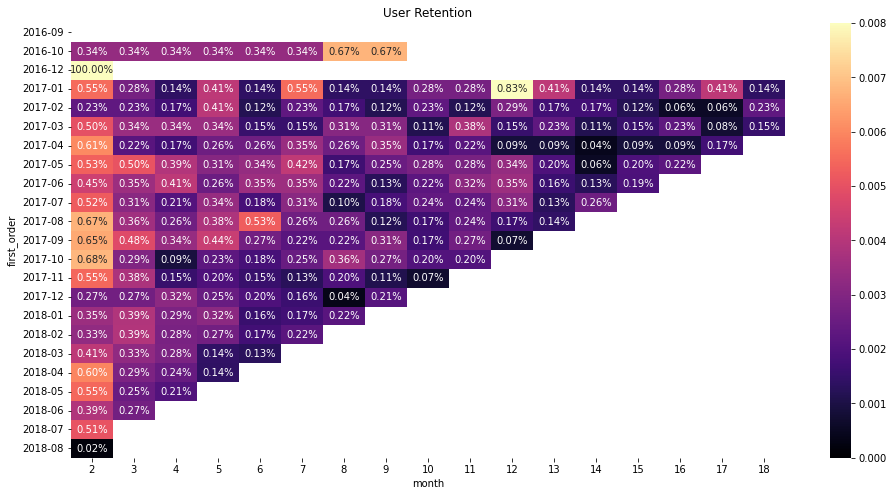

In [40]:
make_cohorts(customers, orders)

В период с января по декабрь с самым высоким retention на 3-й месяц является когорта пользователей, совершивших первую покупку в мае 2017 года.

## 6. Построение RFM-кластеров для пользователей. Для каждого кластера определить средние значения метрик R, F, M (с подробным описанием). 

### Подготовка данных для анализа

Нас будут интересовать только те пользователи, которые оплатили заказ - присутствует информация в колонке подтверждения оплаты order_approved_at. Если на последующих этапах заказ не был доставлен пользователю - то это уже не его проблема. Поэтому будем брать данные только те, где есть оплата order_approved_at. Так же не будем учитывать отмененные заказы (order_status = canceled в данных по заказам orders)

In [41]:
#соеденим три файла:
orders_customers = orders.merge(customers, how='outer', on='customer_id')
orders_customers_items = orders_customers.merge(items, how='outer', on='order_id')
orders_customers_items = orders_customers_items.query('order_status != "canceled"')

#оставим нужные колонки:
orders_customers_items = orders_customers_items[['order_purchase_timestamp', 
                                                 'order_approved_at','order_id', 
                                                 'customer_unique_id', 
                                                 'price']]

#переименуем столбы на более короткие названия:
orders_customers_items = orders_customers_items.rename(columns={'order_purchase_timestamp' : 'date', 
                                                                'customer_unique_id'       : 'customer',
                                                                'order_id'                 : 'order',
                                                                'order_approved_at'        : 'pay_date',
                                                                'price'                    : 'cost'})

#переведем формат даты:
orders_customers_items.date = orders_customers_items.date.dt.date
orders_customers_items.pay_date = orders_customers_items.pay_date.dt.date

#посчитаем нулевые значения:
orders_customers_items.isna().sum()

date          0
pay_date     20
order         0
customer      0
cost        611
dtype: int64

Как мы видим, для 20 строк отсутствует подтверждение оплаты. Еще для 611 отсутствует цена. Эту информацию учитывать не будем. 

In [42]:
orders_customers_items = orders_customers_items.dropna()

#создадим итоговый датафрейм для анализа только с нужными колонками:
rfm = orders_customers_items.groupby(['date', 'customer', 'order'], as_index=False).agg({'cost':'sum'})
rfm.head()

,date,customer,order,cost
0,2016-09-04,b7d76e111c89f7ebf14761390f0f7d17,2e7a8482f6fb09756ca50c10d7bfc047,72.89
1,2016-09-15,830d5b7aaa3b6f1e9ad63703bec97d23,bfbd0f9bdef84302105ad712db648a6c,134.97
2,2016-10-03,10e89fd8e5c745f81bec101207ba4d7d,ef1b29b591d31d57c0d7337460dd83c9,74.90
3,2016-10-03,2f64e403852e6893ae37485d5fcacdaf,be5bc2f0da14d8071e2d45451ad119d9,21.90
4,2016-10-03,32ea3bdedab835c3aa6cb68ce66565ef,3b697a20d9e427646d92567910af6d57,29.90


In [43]:
#'Сегодня' будем считать как последняя дата в rfm + 1 день
last_date = rfm['date'].max() + timedelta(days=1)

In [44]:
#создадим датафрейм с показателями RFM для каждого пользователя:
rfmTable = rfm.groupby('customer')\
              .agg({'date'     : lambda x: (last_date - x.max()).days,
                    'customer' : lambda x: len(x), 
                    'cost'     : 'sum'})

rfmTable.rename(columns={'date'      : 'recency', 
                         'customer'  : 'frequency', 
                         'cost'      : 'monetary'}, inplace=True)

rfmTable = rfmTable.reset_index()
rfmTable.head()

,customer,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,18.90
2,0000f46a3911fa3c0805444483337064,543,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,327,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,294,1,180.00


In [45]:
#посмотрим для какого числа пользоветелей будем строить анализ
rfmTable.customer.nunique()

94976

### Определение границ сегментов

In [46]:
#посмотрим на описательные статистики каждого показателя и построим три попарных графика
rfmTable.describe()

,recency,frequency,monetary
count,94976.000000,94976.000000,94976.000000
mean,244.318565,1.033851,142.085769
std,152.985829,0.210795,216.107543
min,1.000000,1.000000,0.850000
25%,120.000000,1.000000,47.900000
50%,225.000000,1.000000,89.890000
75%,353.000000,1.000000,155.000000
max,730.000000,16.000000,13440.000000


<AxesSubplot:xlabel='monetary', ylabel='recency'>

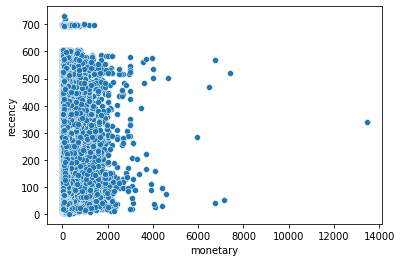

In [47]:
sns.scatterplot(data=rfmTable, x='monetary', y='recency')

Выяснилось, что у нас имеется пробел в данных между 600 и 700 днями. Сейчас не важно, по каким причинам это произошло, важно то, что пользоветелей, которые совершали покупку более 650 дней назад откинем, чтобы они не смещали RFM анализ и его показатели и сегментацию.

In [48]:
rfmTable = rfmTable.query('recency < 650')
rfmTable.customer.nunique()

94690

In [49]:
95407 - 95108

299

Кстати говоря таких пользователей оказалось не много - всего 299. 

<AxesSubplot:xlabel='monetary', ylabel='frequency'>

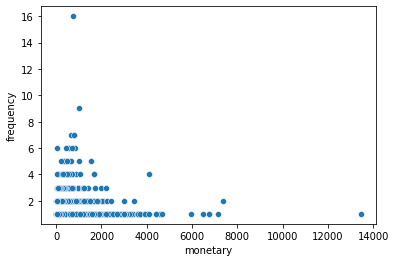

In [50]:
sns.scatterplot(data=rfmTable, x='monetary', y='frequency')

<AxesSubplot:xlabel='recency', ylabel='frequency'>

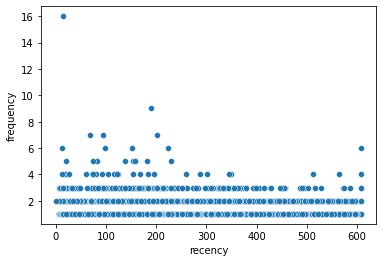

In [51]:
sns.scatterplot(data=rfmTable, x='recency', y='frequency')

In [52]:
rfmTable.frequency.unique()

array([ 1,  2,  3,  4,  6,  7,  5,  9, 16], dtype=int64)

### Вариант 1 - Приоретизация пользователям, покупающим чаще и больше

Самый интересный момент в RFM анализе - определение границ сегментов. Как мы видим, наименьшую изменчивоть имеет частота (frequency), для которой мы имеем всего 9 уникальных значений. С неё мы и начнем. 

Нам точно стоит выделить сегмент пользователей, которые совершили только одну покупку. Так же имеет смысл выделить одного пользователя, который совершил 16 покупок и существенно отличается от второго по этому показателю. Дальше по этому же принципу для recency и monetary, в максимальном сегменьте мы будем выделять только тех пользователей, которые существенно отличаются от других. Итого у нас остается 2, 3, 4, 5, 6, 7, 9. 

Чтобы выделить следующие два сегмента посмотрим сколько в каждом пользователей:

In [53]:
rfmTable.groupby('frequency').agg({'customer':'count'})

,customer
frequency,
1,91807
2,2647
3,188
4,29
5,9
6,5
7,3
9,1
16,1


Выделим ещё два сегмента (2, 3) и (4, 5, 6, 7, 9). 

#### F сегменты:
- 4 количество заказов больше 15
- 3 количество заказов 4-15
- 2 количество заказов 2-3
- 1 количество заказов 1

Теперь посмотрим на распределение recency

C:\Users\pletn\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='recency'>

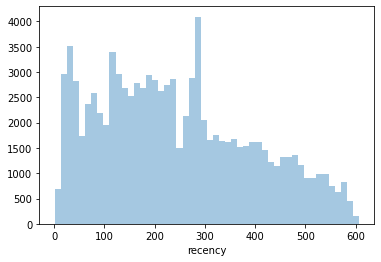

In [54]:
sns.distplot(rfmTable.recency, kde=False)

In [55]:
rfmTable.query('recency <= 7').recency.count()

51

In [56]:
rfmTable.query('recency <= 30').recency.count()

5225

In [57]:
rfmTable.query('recency <= 120').recency.count()

23796

Гриницы сегментов по последнему посещению выберем исходя из календарных значений: неделя, месяц, квартал.
#### R сегменты:
- 4 меньше или равно 7 дней
- 3 от 7 до 30
- 2 от 30 до 120
- 1 выше 120

Теперь посмотрим на распределение monetary

<AxesSubplot:xlabel='monetary'>

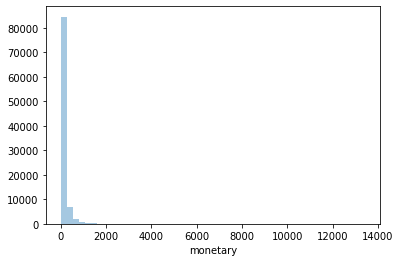

In [58]:
sns.distplot(rfmTable.monetary, kde=False)

In [59]:
#посмотрим на ТОП 30
rfmTable.sort_values('monetary', ascending=False).head(30)

,customer,recency,frequency,monetary
3788,0a0a92112bd4c708ca5fde585afaa872,340,1,13440.00
81004,da122df9eeddfedc1dc1f5349a1a690c,521,2,7388.00
43937,763c8b1c9c68a0229c42c9fc6f662b93,51,1,7160.00
81843,dc4802a71eae9be1dd28f5d788ceb526,569,1,6735.00
25902,459bef486812aa25204be022145caa62,41,1,6729.00
94689,ff4159b92c40ebe40454e3e6a7c35ed6,468,1,6499.00
23842,4007669dec559734d6f53e029e360987,284,1,5934.60
88645,eebb5dda148d3893cdaf5b5ca3040ccb,504,1,4690.00
27125,48e1ac109decbb87765a3eade6854098,74,1,4590.00
60206,a229eba70ec1c2abef51f04987deb7a5,96,1,4400.00


Как говорили ранее в 4 сегмент будут попадать только совсем исключительные случаи. По monetary это пользователь с общей суммой затрат 13440, что существенно больше чем у ближайшего. Границу определим как 10000 и больше. В 3 сегмент по recency и friqency попало от 48 до 9324 пользователей. Для monetary выберем третий сегмент так, чтобы в него попало пользователей в таком же диапазоне.

In [60]:
rfmTable.query('monetary > 1000')\
        .groupby('monetary')\
        .agg({'customer':'count'}).customer.sum()

957

C:\Users\pletn\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 1000.0)

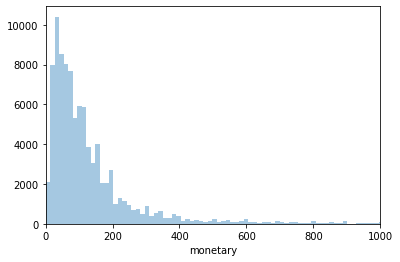

In [61]:
sns.distplot(rfmTable.monetary, kde=False, bins=1000)
plt.xlim(0, 1000)

In [62]:
rfmTable.query('monetary > 200 & monetary < 1000 ')\
        .groupby('monetary')\
        .agg({'customer':'count'}).customer.sum()

14314

#### M сегменты:
- 4 больше 10000
- 3 от 1000 до 10000
- 2 от 200 до 1000
- 1 меньше 200

### Определение средних значений для каждого сегмента RFM модели. Опделение пользователей в каждом сегменте

In [63]:
#напишем функцию преобразования колонки для первого варианта R
def R1_spliter(column):
    if column <= 7:
        return 4
    if column > 7 and column <= 30:
        return 3
    if column > 30 and column <= 120:
        return 2
    if column > 120:
        return 1
#напишем функцию преобразования колонки для первого варианта F
def F1_spliter(column):
    if column > 15:
        return 4
    if column >= 4 and column <= 15:
        return 3
    if column >= 2 and column <= 3:
        return 2
    if column == 1:
        return 1
#напишем функцию преобразования колонки для первого варианта M
def M1_spliter(column):
    if column > 10000:
        return 4
    if column >= 1000 and column < 10000:
        return 3
    if column >= 200 and column < 1000:
        return 2
    if column < 200:
        return 1

In [64]:
rfmTable['R1'] = rfmTable['recency'].apply(R1_spliter)
rfmTable['F1'] = rfmTable['frequency'].apply(F1_spliter)
rfmTable['M1'] = rfmTable['monetary'].apply(M1_spliter)
rfmTable.head()

,customer,recency,frequency,monetary,R1,F1,M1
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,2,1,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,18.90,2,1,1
2,0000f46a3911fa3c0805444483337064,543,1,69.00,1,1,1
3,0000f6ccb0745a6a4b88665a16c9f078,327,1,25.99,1,1,1
4,0004aac84e0df4da2b147fca70cf8255,294,1,180.00,1,1,1


In [65]:
rfmTable['RFM1'] = rfmTable['R1'].astype(str) + rfmTable['F1'].astype(str) + rfmTable['M1'].astype(str)
rfmTable.head()

,customer,recency,frequency,monetary,R1,F1,M1,RFM1
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,2,1,1,211
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,18.90,2,1,1,211
2,0000f46a3911fa3c0805444483337064,543,1,69.00,1,1,1,111
3,0000f6ccb0745a6a4b88665a16c9f078,327,1,25.99,1,1,1,111
4,0004aac84e0df4da2b147fca70cf8255,294,1,180.00,1,1,1,111


In [66]:
rfm_mean1 = rfmTable.groupby('RFM1')\
                    .agg({'recency' : 'mean',
                          'frequency': 'mean',
                          'monetary' : 'mean'})\
                    .rename(columns={'recency'   : 'recency_mean',
                                     'frequency' : 'frequency_mean',
                                     'monetary'  : 'monetary_mean'})\
                    .round(1)
rfm_mean1

,recency_mean,frequency_mean,monetary_mean
RFM1,,,
111,303.0,1.0,81.1
112,306.4,1.0,371.9
113,313.2,1.0,1573.2
114,340.0,1.0,13440.0
121,295.8,2.0,118.3
122,284.0,2.1,371.7
123,284.7,2.1,1643.3
131,575.7,4.7,54.9
132,215.2,4.6,523.9


In [67]:
rfm_clients1 = rfmTable.groupby(['R1', 'F1', 'M1'])\
                       .agg({'recency': 'count'})\
                       .rename(columns={'recency':'clients'})
rfm_clients1

clients
R1 F1 M1         
1  1  1     58180
      2      9988
      3       652
      4         1
   2  1      1173
      2       836
      3        39
   3  1         3
      2        20
      3         2
2  1  1     15164
      2      2572
      3       189
   2  1       336
      2       276
      3        20
   3  2        12
      3         2
3  1  1      4329
      2       633
      3        52
   2  1        80
      2        70
      3         1
   3  2         6
      3         2
   4  2         1
4  1  1        42
      2         5
   2  1         1
      2         3

In [68]:
rfmTable['total_rfm_score1'] = rfmTable.R1 + rfmTable.F1 + rfmTable.M1
rfmTable.groupby('total_rfm_score1')\
        .agg({'customer': 'count'})\
        .rename(columns={'customer' : 'total_rfm_score1'})

,total_rfm_score1
total_rfm_score1,
3,58180
4,26325
5,8728
6,1280
7,162
8,12
9,3


Особенность данного подхода заключается в том, что мы хорошо выделяем небольшую группу пользователей, которые совершают покупки на большие суммы, часто и недавно, и для этих сверхлояльных пользователей мы могли бы сделать очень выгодные персональные предложения. На рейтинги 6-9 приходится всего не больше 1500 пользователей.

### Вариант 2 - Приоритет "среднему" пользователю

В первом варианте мы выделели три сегмента и четвертый для самого ТОПа пользователей в каждой категории. В этом варианте возьмем только три сегмента и постараемся сделать их равномерно распределенными.

In [69]:
rfmTable.groupby('frequency')\
        .agg({'customer':'count'})

,customer
frequency,
1,91807
2,2647
3,188
4,29
5,9
6,5
7,3
9,1
16,1


Самый взвешенный вариант с частотой при трех сегментах возможен при следующем:
- 1 балл пользователей совершившие единичную покупку
- 2 балла пользователи совершившие две покупки
- 3 балла пользователей совершившие три и более покупки 

Для давности посмотрим на 33 и 66 процентиль:

In [70]:
rfmTable.recency.quantile(q=0.33)

153.0

In [71]:
rfmTable.recency.quantile(q=0.66)

292.0

Округлим до полугода:
- 1 балл пользователей совершившие покупку больше 292 дня назад
- 2 балла 153 - 292
- 3 балла больше 292

По деньгам так же возьмем 33 и 66 процентиль:

In [72]:
rfmTable.monetary.quantile(q=0.33)

57.99

In [73]:
rfmTable.monetary.quantile(q=0.66)

124.99

По деньгам получим сегменты:
- 1 балл пользователей совершившие покупку менее чем на 58 долларов
- 2 балла 58 - 360 долларов
- 3 балла больше 125

In [74]:
#напишем функцию преобразования колонки для второго варианта R
def R2_spliter(column):
    if column <= 153:
        return 3
    if column > 153 and column <= 292:
        return 2
    if column > 292:
        return 1
#напишем функцию преобразования колонки для второго варианта F
def F2_spliter(column):
    if column > 2:
        return 3
    if column == 2:
        return 2
    if column == 1:
        return 1
#напишем функцию преобразования колонки для второго варианта M
def M2_spliter(column):
    if column > 125:
        return 3
    if column >= 58 and column <= 125:
        return 2
    if column < 58:
        return 1

In [75]:
rfmTable['R2'] = rfmTable['recency'].apply(R2_spliter)
rfmTable['F2'] = rfmTable['frequency'].apply(F2_spliter)
rfmTable['M2'] = rfmTable['monetary'].apply(M2_spliter)
rfmTable['RFM2'] = rfmTable['R2'].astype(str) + rfmTable['F2'].astype(str) + rfmTable['M2'].astype(str)
rfmTable['total_rfm_score2'] = rfmTable.R2 + rfmTable.F2 + rfmTable.M2
rfmTable.head()

,customer,recency,frequency,monetary,R1,F1,M1,RFM1,total_rfm_score1,R2,F2,M2,RFM2,total_rfm_score2
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,2,1,1,211,4,3,1,3,313,7
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,18.90,2,1,1,211,4,3,1,1,311,5
2,0000f46a3911fa3c0805444483337064,543,1,69.00,1,1,1,111,3,1,1,2,112,4
3,0000f6ccb0745a6a4b88665a16c9f078,327,1,25.99,1,1,1,111,3,1,1,1,111,3
4,0004aac84e0df4da2b147fca70cf8255,294,1,180.00,1,1,1,111,3,1,1,3,113,5


In [76]:
rfm_mean2 = rfmTable.groupby('RFM2')\
                    .agg({'recency' : 'mean',
                          'frequency': 'mean',
                          'monetary' : 'mean'})\
                    .rename(columns={'recency'   : 'recency_mean',
                                    'frequency' : 'frequency_mean',
                                    'monetary'  : 'monetary_mean'})\
                    .round(1)
rfm_mean2

,recency_mean,frequency_mean,monetary_mean
RFM2,,,
111,421.7,1.0,34.4
112,418.6,1.0,86.7
113,419.6,1.0,308.0
121,430.5,2.0,43.4
122,407.5,2.0,94.4
123,406.7,2.0,334.7
131,573.4,3.2,37.0
132,445.1,3.6,86.9
133,392.0,3.1,412.7


In [77]:
rfm_clients2 = rfmTable.groupby(['R2', 'F2', 'M2'])\
                       .agg({'recency': 'count'})\
                       .rename(columns={'recency':'clients'})
rfm_clients2

clients
R2 F2 M2         
1  1  1     10461
      2     10622
      3     10089
   2  1        72
      2       218
      3       503
   3  1         5
      2         7
      3        52
2  1  1     10502
      2      9868
      3      9982
   2  1        56
      2       209
      3       656
   3  1         1
      2         9
      3        55
3  1  1     10102
      2     10208
      3      9973
   2  1        62
      2       235
      3       636
   3  2        11
      3        96

### Отдаем результаты менеджеру на ревью
Показываем менеджеру Василию первый вариант (распределение пользователей по сегментам rfm_clients1 и средние в каждом сегменте rfm_mean1) с приоритезацией и выявлением самых покупающих и тратящих пользователей, которых стоит удерживать и второй вариант (распределение пользователей по сегментам rfm_clients2 и средние в каждом сегменте rfm_mean2) с приоритезайцией и выявлением среднестатистического пользователя, с которыми стоит работать над увеличением числа заказов и общей суммы покупок для перехода в сегменты выше. Дальше совместно, исходя из реальной маркетинговой компании и бюджета, думаем как построить третий вариант, сколько в нем будет сегментов и как лучше выбрать границы, который лучше всего подойдет маркетинговой компании и бизнесу.

<AxesSubplot:xlabel='total_rfm_score1', ylabel='customers'>

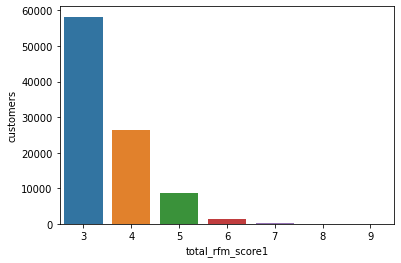

In [78]:
#распределение пользователей по общему баллу RFM для первого варианта
rfmcustomersdist1 = data= rfmTable.groupby('total_rfm_score1', as_index=False)\
                                  .agg({'customer': 'count'})\
                                  .rename(columns={'customer' : 'customers'})
sns.barplot(data= rfmcustomersdist1, x='total_rfm_score1', y='customers')

<AxesSubplot:xlabel='total_rfm_score2', ylabel='customers'>

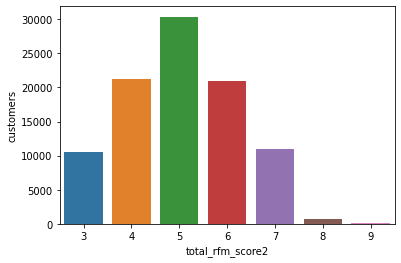

In [79]:
#распределение пользователей по общему баллу RFM для второго варианта
rfmcustomersdist2 = data= rfmTable.groupby('total_rfm_score2', as_index=False)\
                                  .agg({'customer': 'count'})\
                                  .rename(columns={'customer' : 'customers'})
sns.barplot(data= rfmcustomersdist2, x='total_rfm_score2', y='customers')

# Summary

#### 1. Сколько у нас пользователей, которые совершили покупку только один раз? 
- 90549 пользователей совершили покупку (заказ, order) только один раз. При этом не доставленные заказы и отмененные не учтены.

#### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?
- данные записаны в not_delivered_by_reason

In [80]:
not_delivered_by_reason

,order_status,monthly_mean
0,approved,0.083333
3,invoiced,13.083333
4,processing,12.541667
5,shipped,46.125000
2,delivered,0.333333
6,unavailable,25.375000
1,canceled,19.916667


Возможные причины для каждого статуса, из-за чего заказ не был доставлен клиенту:
- approved —  подтверждён. Внутреняя ошибка сервиса. 
- invoiced —  выставлен счёт. Клиент не оплатил заказ. 
- processing —  в процессе сборки заказа. Заказ отсутствует на складе. 
- shipped —  отгружен со склада. Был утерян курьерской службой.
- delivered —  доставлен пользователю. Доставлен неверный заказ. 
- unavailable —  недоступен
- canceled —  отменён

#### 3. По каждому товару определить, в какой день недели товар чаще всего покупается.
- prod_best_weekday_1 - для каждого товара определены все дни недели, в которые он был куплен максимальное количество раз.
- prod_best_weekday_2 - для каждого товара определен только один единственный день недели, в который покупок было больше, чем в другие дни.
- третий вариант с проверкой статистических различий, при необходимости после диалога с менеджером Василием

#### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?
- Среднее количество покупок в неделю для каждого пользователя записано в датафрейм avg_products_per_week.


In [81]:
avg_products_per_week.head(3)

year_month,2016-09,2016-10,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,...,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.225806,0.0,0.0,0.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.225806,0.0,0.0,0.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,0.0,0.0,0.0,0.225806,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


- Строки - уникальные номера пользоваталей (customer_unique_id), 
- Столбцы - месяц в формате год_месяц даты оплаты заказа, 
- Значения - среднее количество купленых товаров в месяц

#### 5. Напиши функцию на python, позволяющую строить когортный анализ. 
- функция make_cohorts (x, y), где х данные о пользоваетелях (customers), а у данные о заказах (orders)

#### В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц. Описание подхода можно найти тут.
- В период с января по декабрь с самым высоким retention на 3-й месяц является когорта пользователей, совершивших первую покупку в мае 2017 года.

#### 6. Построй RFM-кластеры для пользователей. 
- данные о количестве пользователей в каждом кластере записаны в rfm_clients1 (развесовка на наиболее лояльных)
- для среднячковых пользователей во втором варианте данные записаны в rfm_clients2

#### Выведи для каждого кластера средние значения метрик R, F, M. 
- средние значения R, F, M записаны в rfm_mean1 (развесовка по наиболее лояльным)
- для среднячковых пользователей данные записаны в rfm_mean2

Более подробно см. полный раздел.